<a href="https://colab.research.google.com/github/kaiyoyume/zerodeeplearning_2/blob/main/%EF%BC%92%E7%AB%A0%E3%80%80%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E3%81%A8%E5%8D%98%E8%AA%9E%E3%81%AE%E5%88%86%E6%95%A3%E8%A1%A8%E7%8F%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#２章　自然言語と単語の分散表現

##2.1 自然言語処理とは
自然言語(Natural Language)：日本語や英語など、私たちが普段使っている言葉。  

自然言語処理（Natural Language Processing：NLP）:自然言語をコンピュータに理解させる技術（分野）

##2.1.1 単語の意味
私たちの言葉は「文字」によって構成される。  
私たちの言葉の意味は「単語」によって構成される。  
単語は、意味の最小単位。  
そのため、自然言語をコンピュータに理解させるためには、「単語の意味」を理解させることが重要。  

「単語の意味」をうまく捉えた表現方法


*   シソーラスによる手法
*   カウントベースによる手法
*   推論ベースの手法(word2vec) ※次章



##2.2 シソーラス
シソーラス(thesaurus)とは（基本的には）、類似辞書である。   
「同じ意味の単語（同義語）」や「意味の似た単語（類似語）」が同じグループに分類されている。

単語の意味を人手によって定義する。


同義語の例

`car` = `auto` `automobile` `machine` `motorcar`





###2.2.1 WordNet
自然言語処理の分野において、最も有名なシソーラスは**WordNet**である。

###2.2.2 シソーラスの問題点

*   時代の変化に対応するのが困難
*   人の作業コストが高い
*   単語の細かなニュアンスを表現できない




##2.3 カウントベースの手法
カウントベースの手法に進むにあたって、コーパス(corpus)を使う。  
コーパスとは、自然言語処理の研究やアプリケーションのために目的をもって種集されたテキストデータ。

###2.3.1 Pythonによるコーパスの下準備
コーパスの有名な例：WikipediaやGoogle Newsなどのテキストデータ、シェイクストピアや夏目漱石など、偉大な作家の作品群

まず初めに１文からなる単純なテキストをコーパスとして利用する。  
そのあとで、より実用的なコーパスを扱う。

In [ ]:
#コーパスとして利用するサンプルの文章

text = 'You say goodbye and I say hello.'

これで、元の文章を単語のリストとして利用できるように分割する。

In [ ]:
#分割のための下準備

text = text.lower() #すべての文字を小文字に変換
text= text.replace('.', ' .')
text

'you say goodbye and i say hello .'

In [ ]:
words = text.split(' ') #単語単位に分割
words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

単語IDと単語の対応表をPythonのディクショナリで作成する。

In [ ]:
word_to_id = {} #単語IDから単語への変換表
id_to_word = {} #単語から単語IDへの変換表

for word in words:
  if word not in word_to_id:
    new_id = len(word_to_id)
    word_to_id[word] = new_id
    id_to_word[new_id] = word

In [ ]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [ ]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

このディクショナリを使えば、単語から単語IDを検索したり、逆に単語IDから単語を探索したりすることができる。

In [ ]:
id_to_word[1]

'say'

In [ ]:
word_to_id['hello']

最後に、「単語のリスト」を「単語のIDのリスト」にPythonの内包表記を使って、変換する。
そして、それをNumpy配列に変換する。

In [ ]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

これで、コーパスを利用する下準備が整った。  
以上の処理をpreprocess()という名前の関数でまとめて実装する。

#### preprocess関数

In [ ]:
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
  
  corpus = np.array([word_to_id[w] for w in words])

  return corpus, word_to_id, id_to_word

In [ ]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word=preprocess(text)

これでコーパスの前処理が終わった。

###2.3.2 単語の分散処理  
「単語の意味」を的確に捉えたベクトル表現を、自然言語処理の分野では、**単語の分散表現**と呼ぶ。  
単語の分散表現は、単語を固定長のベクトルで表現する。

###2.3.3 分布仮説
分布仮説（distributional hypothesis）・・・「単語の意味は、周囲の単語によって形成される」

コンテキスト・・・（注目する単語に対して）その周囲に存在する単語  
ウィンドウサイズ(window size)・・・コンテキストのサイズ

### 2.3.4 共起行列
共起行列・・・自然言語処理において、文書や文章中に含まれる単語の出現頻度を表現する行列。

分布仮説に基づいて、単語をベクトルで表す方法を考える。  
素直な方法は、ある単語に着目した場合、その周囲にどのような単語がどれだけ現れるのかをカウントし。それを集計する。  
ここでは、これをカウントベースの手法と呼ぶ。  

まずコーパスの下準備をする。

In [ ]:
import numpy as np

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word=preprocess(text)

In [ ]:
print(corpus)

[0 1 2 3 4 1 5 6]


In [ ]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


上の結果より、ここでは語彙数が全部で7個あることが分かる。  
それでは、それぞれの単語について、そのコンテキストに含まれる単語の頻度を数えていく。  
ここでは、ウィンドウサイズを１とする。

図2-7のテーブルは、すべての単語に対して、共起する単語をまとめたものである。  
このテーブルの各行が、該当する単語のベクトルに対応する。  
なお、図2-7のテーブルは行列の形をしているため、共起行列(co-occurence matrix)と呼ばれる。

In [ ]:
text = 'You say goodbye and I say hello.'

　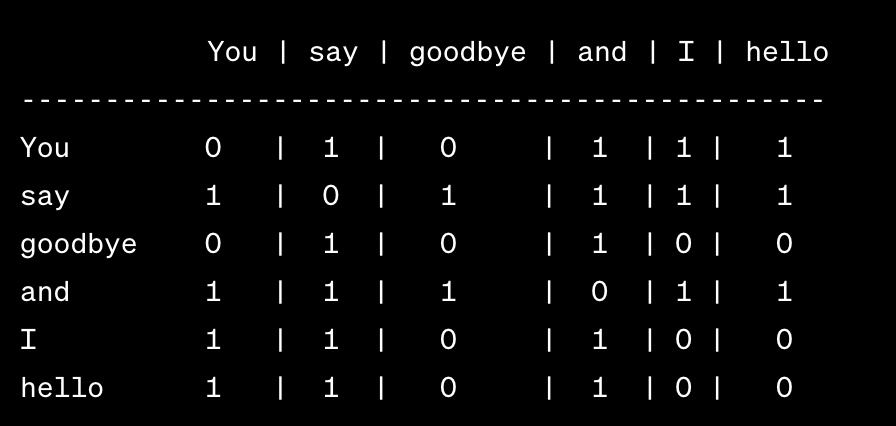


図： 各単語について、そのコンテキストに含まれる単語に頻度をカウントし、テーブルにまとめる

#### create_co_matrix関数

In [ ]:
def create_co_matrix(corpus, vocab_size, window_size=1):
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

  for idx, word_id in enumerate(corpus):
    for i in range(1, window_size + 1):
      left_idx = idx - i
      right_idx = idx + i

      if left_idx >= 0:
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1

      if right_idx < corpus_size:
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1

  return co_matrix

In [ ]:
import numpy as np
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
C

array([[0, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

Cは、すべての単語に対して、共起する単語をまとめたものである。
このテーブルの各行が、該当する単語のベクトルに対応する。

例えば、0行目は'you'、１行目は'say'、6行目は'.'に対応している。

Cは行列の形をしているため、共起行列(co-occurence matrix)と呼ばれる。

create_co_matrix関数を使えば、コーパスがどれだけ大きくなったとしても、自動で共起行列を作ることができる。

###2.3.5 ベクトル間の類似度
共起行列によって、単語をベクトルで表すことができた。
続いてベクトル間の類似度を計測していく。

ベクトル間の類似度を計測するには、さまざまな方法が考えられる。  
たとえば、ベクトルの内積やユークリッド距離などが代表例に挙げられる。  
保単語のベクトル表現の類似度に関しては、コサイン類似度（cosine similarity）がよく用いられる。  
コサイン類似度は、$x=(x_1,x_2,x_3,...,x_n)$と$y=(y_1,y_2,y_3,...,y_n)$の２つのベクトルがあとき、次の式で定義される。  

$$
similarity(x,y)=\frac{x*y}{||x||||y||}=\frac{x_1y_1+...+x_ny_n}{\sqrt{x_1^2+...x_n^2}\sqrt{y_1^2+...y_n^2}}
$$

コサイン類似度を実装する。
#### cos_similarity関数


In [ ]:
def cos_similarity(x,y,eps=1e-8):
  nx = x / np.sqrt(np.sum(x**2) + eps) #xの正規化
  ny = y / np.sqrt(np.sum(y**2) + eps) #yの正規化
  return np.dot(nx, ny)

この関数を用いると、単語ベクトルの類似度は次にように求めることができる。  
ここでは、「you」と「i(=I)」の類似度を求めてみる。  

In [ ]:
import numpy as np
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] #「you」の単語ベクトル
c1= C[word_to_id['i']]     #「i」の単語ベクトル
print(cos_similarity(c0, c1))

0.7071067758832467


「you」と「i」のコサイン類似度は、0.70...という結果になった。  
コサイン類似度は、１から−１までを取るので、この値は、比較的高い値(類似性がある)と言えそう。

###2.3.6 類似単語のランキング表示
コサイン類似度の関数を使って、ある単語がクエリとして与えられた時に、そのクエリに対して類似した単語を上位から順に表示する関数を作りたい。  
ここでは、その実数をmost_similar()と呼び、次のような引数で実装する。


*   query 　　　クエリ（単語）
*   word_to_id 　単語から単語IDへのディクショナリ 
*   id_to_word 　単語IDから単語へのディクショナリ
*   word_matrix 単語ベクトルをまとめた行列、各行に対応する単語のベクトルが格納されていることを想定する。  
*   top 　　　　上位何位まで表示するか



####  most_similar関数

In [ ]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
  #①クエリを取り出す
  if query not in word_to_id:
    print('%s is not found' % query)
    return

  print('\n[query] ' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]
  
  #②コサイン類似度の算出
  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)
  for i in range(vocab_size):
    similarity[i] = cos_similarity(word_matrix[i], query_vec)
  
  #③コサイン類似度の結果から、その値を高い順に出力
  count = 0
  for i in (-1*similarity).argsort():
    if id_to_word[i] == query:
      continue
    print(' %s: %s' % (id_to_word[i], similarity[i]))

    count += 1
    if count >= top:
      return

In [ ]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067758832467
 i: 0.7071067758832467
 hello: 0.7071067758832467
 say: 0.0
 and: 0.0


「you」という単語のクエリに対して類似単語を上位から順に５つ表示している。 各単語の隣に、コサイン類似度の値を表示している。

##2.4 カウントベース手法の改善
前節では、単語の共起行列を作った。それによって単語をベクトルで表すことには成功した。  
しかし、その共起行列にはまだまだ改善すべきところがある。  


###2.4.1 相互情報量
前節の共起行列の要素は、２つの単語が共起した回数を表している。  
しかし、高頻度単語（多く出現する単語）に目を向けると、あまり良い性質を持たないことが分かる。  

たとえば、あるコーパスの「the」と「car」の共起について。  
「...the car...」というフレーズが多くみられるため、その共起する回数は大きな値になる。  
一方、「car」と「drive」という単語には明らかに強い関連性がある。  
しかし、単に出現回数だけをみてしまうと、「car」は「drive」よりも「the」の方に強い関連性を持ってしまう。  
つまりこれは「the」という単語が高頻度な単語であるがゆえに、「car」と強い関連性を持つように評価されてしまう。  

その問題を解決するために、**相互情報量**（Pointwise Mutual Information）と呼ばれる指標が使われる（以降、PMIと略記）。  
PMIは、xとyという確率変数に対して次の式で定義される。  


$$
PMI(x,y)=\log_2\frac{P(x,y)}{P(x)P(y)}
$$

P(x)はxが起こる確率、P(y)はyが起こる確率を表す。  
P（x、y）は、xとyが同時に起こる確率を表す。  
このPMIは、その値が高いほど関連性が高いことを示す。

PMIは、２つの単語で共起する回数が0の場合、$log_2{0}=-∞$となってしまう。
実践上では正の相互情報量(Positive PMI)を使う（以降PPMIと略記）。

$$
PPMI(x,y)= max(0, (PMI(x,y))
$$

PMIがマイナスのときは0として扱い、単語感の関連度を０以上の実数で表す。


#### ppmi関数
共起行列だけから、PPMI行列を求める簡易的な実装

In [ ]:
def ppmi(C, verbose=False, eps=1e-8): #C：共起行列、verbose：進行状況を出力するかどうか、
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C)
  S = np.sum(C, axis=0)
  total = C.shape[0] * C.shape[1]
  cnt = 0

  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
      M[i,j] = max(0,pmi) #共起回数が0の場合に、log0　=　-∞となるを防ぐために性の相互情報量を使う。PMIが-のときは０として扱う。

      if verbose:
        cnt += 1
      
      if cnt % (total//100 + 1) == 0:
        print('%.lf%% done' % (100*cnt/total))
  return M

共起行列のPPMI行列への変換を実装

In [ ]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) #有効桁3桁で表示
print('covariance matrix')
print(C)
print('-'*50)
print('PPMI')
print(W)

0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


これで、共起行列をPPMI行列に変換することができた。  
このとき、PPMI行列の各要素は0以上の実数値である。  
相互情報量を使い、より良い指標からなる行列ーより良い単語ベクトルーを手にできた。

しかし、このPPMI行列にも、まだ大きい問題がある。  

それは、コーパスの語彙数が増えるにつれて、各単語のベクトルの次元数も増えていくという問題である。  
たとえば、コーパスに含まれる語彙数が10万に達すれば、そのベクトルの次元数も同様に10万になる。  

また、この行列の中身を以てみると、その要素の多くは０であることがわかる。  
これは、ベクトルのほとんどの要素が需要でない、つまり、ベクトルの各要素の持つ”重要度”は低いということを意味する。  

そのようなベクトルはノイズに弱く、頑健性に乏しい。

こういった問題に対してよく行われるのが、ベクトルの次元削減である。

###2.4.2 次元削減
次元削減(dimensionality reduction)は、文字どおり、ベクトルの次元を削減する手法を指す。  
ただし、単に削減するのではなく、”重要な情報”をできるだけ残した上で削減するというところがポイントである。  



次元削減を行う方法はいくつかあるが、ここでは**特異値分解**(Singular Value Decomposition：SVD)を使った次元削減を行う。  
SVDは、任意の行列を３つの行列の積へと分解する。  
数式で書くと、次のように表される。  
$$
X = USV^T
$$

UとVは直行行列であり、その列ベクトルはお互いに直交する。  
また、Sは対角行列であり、これは対角成分以外はすべて０の行列である。

直交行列のUは、何らかの空間の軸（基底）を形成している。  
このUという行列を「単語空間」として扱う。
  
また、Sは対角行列で、この対角成分には、「特異値」というものが大きい順に並んでいる。
特異値とは、簡単に言えば、「対応する軸」の重要度と見なすことができる。

そこで、重要でない要素を削ることが考えられる。

行列Sの特異値が小さいものは重要度が低いので、行列Uから余分な列ベクトルを削ることで、元の行列を近似することができる。

これを「単語のPPMI行列」に当てはめると、行列Xの各行には対応する単語IDの単語ベクトルが格納されており、それらの単語ベクトルが行列U'として次元削減されたベクトルで表現されることになる。


###2.4.3 SVDによる次元削減
Pythonで実際に、SVDを行ってみる。  
このSVDはNumpyのlinalgモジュールにあるsvdというメソッドで実行できる。  
ちなみに、linalgとはlinear algebra(線形代数)の略称である。  

それでは、共起行列を作り、PPMI行列に変換し、それに対してSVDを適用する。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)  #UにSVDによって変換された密なベクトル表現が格納されている。

np.set_printoptions(precision=3)  # 有効桁３桁で表示

0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done
0% done


単語IDが０の単語ベクトルを見てみる。

In [ ]:
print(C[0]) #共起行列
print(W[0]) #PPMI行列
print(U[0]) #SVD

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


上の結果が示すとおり、元は疎なベクトルであったW[0]が、SVDによって密なベクトルU[0]に変換されている。  
そして、この密なベクトルを次元削減するには、たとえば、それを２次元のベクトルに削減するのであれば、単に先頭の２つの要素を取り出す。

In [ ]:
print(U[0,:2])

[ 3.409e-01 -1.110e-16]


これで、次元削減は終わり。  
最後に、各単語を２次元のベクトルで表し、それをグラフにプロットしてみる。

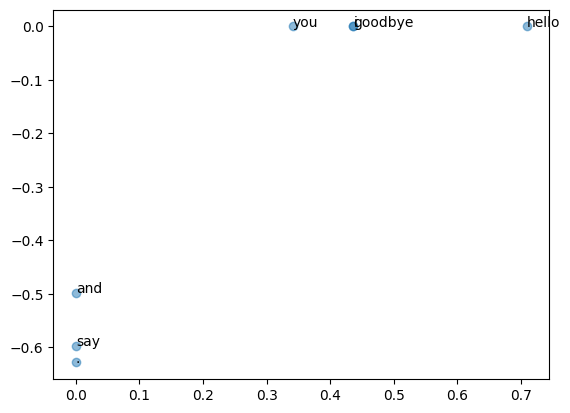

In [ ]:
# plot
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))  #plt.annotate(word,x,y)：２次元のグラフ上の座標が(x,y)の地点にwordというテキストを描画
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

図2-11 共起行列に対してSVDを行い、各単語を２次元ベクトルにしてグラフにプロットする（※「i」と「goodbye」が重なっている）

このプロット図を見ると「goodbye」と「hello」、「you」と「i」が近い場所に位置することが分かる。  

これは私たちの直感と比較的近い。
しかし、ここでは小さなコーパスを使っている関係で、この結果は微妙なものである。  

それでは続いてPTBデータセットという、より大きなコーパスを使って同じ実験を行う。

###2.4.4　PTBデータセット
これまで、とても小さなテキストデータをコーパスとして使用してきた。  
ここでは、”本格的”なコーパス、それでいて大きすぎない手ごろなコーパスを利用する。  
それは、Penn Treebankと呼ばれるコーパスである（以降PTBと略して表記）。

PTBコーパスはテキストファイルで提供されていて、元となるPTBに対してレアな単語を<unk>（unknownという意味）に置き換えたり、具体的な数字を「N」で置き換えるといった前処理が施されている。

まず、Google Colabでnltkをインストール。

In [ ]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('treebank')
from nltk.corpus import treebank

# PTBデータセットを取得する
ptb = ' '.join(treebank.words())

# 前処理関数を実行する
corpus, word_to_id, id_to_word = preprocess(ptb)

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['board']:", word_to_id['board'])

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


corpus size: 107024
corpus[:30]: [ 0  1  2  3  4  5  2  6  7  8  9 10 11 12 13 14 15 16 17 15 18 15  1 19
 20 21 22 23 24 15]

id_to_word[0]: pierre
id_to_word[1]: vinken
id_to_word[2]: ,

word_to_id['car']: 5556
word_to_id['happy']: 6622
word_to_id['board']: 9


### 2.4.5 PTBデータセットでの評価

大きな行列にSVDを行うため、より高速なsklearnモジュールをインストールして使う。

sklearnのrandomized_svd()というメソッドを利用する。  
これは、乱数を使ったTruncated SVDで、特異値の大きものだけに限定して計算することで、通常のSVDよりも高速な計算が行える。


In [ ]:
# 今まで作ってきた関数most_similar, cos_similarity, create_co_matrix, ppmiを使う。

import numpy as np

# PTBデータセットを取得する
ptb = ' '.join(treebank.words())


window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = preprocess(ptb)
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'nissan']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting  co-occurrence ...
calculating PPMI ...
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done
calculating SVD ...

[query] you
 stuff: 0.721226155757904
 we: 0.696

「you」というクエリに対して、「we」や「i」の人称代名詞が上位を占めている。
これは文法的な使い方の点で共通の単語である。

また、「year」がクエリの場合は「week」などの類義語、「nissan」がクエリの場合は企業名が上位を占めている。

このように、単語の意味的な点と文法的な点において似た単語同士が近いベクトルで表された。

もっと大規模なコーパスを使用することで、より優れた単語の分散表現になることが期待できる。

##2.5 まとめ
本章では、自然言語処理を対象として、特に「単語の意味」をコンピュータに理解させることがテーマだった。  

まず、シソーラスを用いた手法は、人の手によって一つづつ単語の関連性を定義する。  
とても大変な作業であり、表現力の点で限界があった。  

一方、カウントベースの手法は、コーパスから自動的に単語の意味を抽出し、それをベクトルで表す。  
具体的には、単語の共起行列を作り、PPMI行列に変換し、ロバスト性を高めるために SVDによる次元削減を行い、各単語の分散表現を得た。  
そして、その分散表現は、意味的に似た単語がベクトルの空間上で互いに近い場所にいることが確認できた。  
